# Congestion Simulation

We simulate the ethereum market in both the status quo and under EIP-1559. Both simulations draw from the same distribution of "values", which quantify the amount that users inherently value their transaction. Both simulations also draw from the same "gas used" distributions.

We first import the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import math
from collections import deque
import matplotlib.pyplot as plt
import cProfile
import random

Throughout the simulation, we keep track of blocks filled and oracle prediction values generated. 

In [2]:
sq_current_oracle = 0
eip_current_oracle = 0 

sq_blocks = []
eip_blocks = []

sq_block_mins =  deque([])
eip_block_mins = deque([])

sq_gas_price_batches = []
eip_gas_price_batches = []

sq_wait_times =[]
eip_wait_times=[]

At every iteration of the simulation, a block is filled with the most lucrative transactions in the mempool, and the mempool is filled again with 2000 transactions. In the function defined below, 2000 samples are taken from the "values" and "gas used" distributions, price mapped to Status Quo and EIP-1559 simulations, and added to the existing mempool. 

In [3]:
def create_mempool(txn_number, sq_df, eip_df, basefee, t=0):
  
    global sq_current_oracle, eip_current_oracle, sq_gas_price_batches, eip_gas_price_batches

    values = np.random.gamma(20.72054, 1/17.49951, txn_number)
    gas_limit = (np.random.pareto(1.42150, txn_number)+1)*21000  # pareto distribution with alpha 1.42150, beta 21000
    
    sq_gas_prices = [sq_current_oracle * v for v in values] 
    eip_gas_prices = [min(basefee + (eip_current_oracle * v), sq_current_oracle * v) for v in values]   
    
    eip_gas_price_batches += [eip_gas_prices]
    sq_gas_price_batches += [sq_gas_prices]
    
    # store each updated mempool as a DataFrame

    sq_df = sq_df.append(pd.DataFrame({
        'gas price': sq_gas_prices,
        'gas limit': gas_limit,
        'time' : t,
        'amount paid': [x * y for x,y in zip(sq_gas_prices,gas_limit)]
        }), ignore_index=True)
    

    eip_df = eip_df.append(pd.DataFrame({
        'gas price': eip_gas_prices,
        'gas limit': gas_limit,
        'time': t,
        'amount paid' : [x * y for x,y in zip(eip_gas_prices,gas_limit)]
        }), ignore_index=True)
    
    # sort transactions in each mempool by gas price
    
    sq_df = sq_df.sort_values(by=['gas price'], ascending=False).reset_index(drop=True)
    eip_df = eip_df.sort_values(by=['gas price'], ascending=False).reset_index(drop=True)
    
    return sq_df, eip_df

We define some helper functions. First, a function to calculate a new basefee. Second, a function to update the oracle values for each transaction. We create a sorted list of the smallest (lowest gas-price) transactions from the previous hundred blocks. The oracle value is defined as the 60th item in that list. Finally, we need functions to fill blocks for both simulations. Because the protocols have different rules on this, we pass a basefee of 0 in the Status Quo simulation and pass in the actual basefee in the EIP-1559 simulation. 

In [4]:
def get_basefee(b, g): 
    
    return b*(1+(1/8)*((g-15000000)/15000000))

def get_oracle():
    
    global sq_current_oracle, sq_block_mins, sq_blocks, eip_block_mins, eip_current_oracle, eip_blocks
    
    update_oracle(sq_current_oracle, sq_block_mins, sq_blocks)
    update_oracle(eip_current_oracle, eip_block_mins, eip_blocks)

def update_oracle(current_oracle, block_minimums, blocks):
    recent_gp = blocks[-1][-1][1]
    block_minimums.popleft()
    block_minimums.append(recent_gp)

    sorted_block_minimums = sorted(block_minimums)
  
    current_oracle = sorted_block_minimums[59]

def fill_block(mempool, basefee, time):
    global eip_wait_times, sq_wait_times
    
    block = []
    block_size = 0
    block_limit = 30000000 if basefee > 0 else 15000000
    
    for i in range(len(mempool)):
        txn = mempool.iloc[i, :].tolist()
        if block_size + txn[1] > block_limit or txn[0] < basefee:
            break
        else:
            block.append(txn)
            block_size += txn[1]
    
    block_wait_times = [time - txn[2] for txn in block]
    if basefee:
        eip_wait_times.append(block_wait_times)
    else:
        sq_wait_times.append(block_wait_times)
    
    #remove verified txns from mempool
    mempool = mempool.iloc[i+1:,:]    
    return block, mempool, block_size

The simulation is ran in the following function, storing data on each iteration. 

In [5]:
def simulate(n):
    
    #initialize empty dataframes
    df1 = pd.DataFrame() 
    df2 = pd.DataFrame() 
    
    sq_block_data = pd.DataFrame()
    eip_block_data = pd.DataFrame()
   
    sq_mempool_data = pd.DataFrame()
    eip_mempool_data = pd.DataFrame()
    
  
    sq_mempools = []
    eip_mempools = []
    eip_mempools_bf = []
    demands = []
    
    global sq_block_mins, eip_block_mins, sq_blocks, sq_current_oracle, eip_current_oracle, eip_blocks, eip_wait_times, sq_wait_times
    
    #read in data to initialize oracle
    data = pd.read_csv('block_data.csv')
    minGasdf = data[['gasLimit','minGasPrice']].values 
    for d in minGasdf:
        if len(eip_block_mins) == 100:
            break
        if d[1] == 'None':
            continue
        sq_block_mins.append(int(d[1]) / 10**9)
        eip_block_mins.append(int(d[1]) / 10**9)
    
    basefee = eip_block_mins[-1]
    basefees = [basefee]
    
    sorted_sq_block_mins = sorted(sq_block_mins)
    sorted_eip_block_mins = sorted([x - basefee if x >= basefee else 0 for x in eip_block_mins])
    
    #set initial oracles
    sq_current_oracle = sorted_sq_block_mins[59]
    eip_current_oracle = sorted_eip_block_mins[59]
    
    #initialize mempools with 700 txns
    sq_mempool, eip_mempool = create_mempool(8500, df1, df2, basefee)
    
    #iterate over n blocks
    for i in range(n):
        
        #fill blocks from mempools
        new_sq_block, new_sq_mempool, sq_blocksize = fill_block(sq_mempool, 0, i)
        new_eip_block, new_eip_mempool, eip_blocksize = fill_block(sq_mempool, basefee, i)
        
        sq_blocks += [new_sq_block]
        eip_blocks += [new_eip_block]
        
        get_oracle()
        
        #update mempools
        sq_mempool = new_sq_mempool
        eip_mempool = new_eip_mempool
        
        basefee = get_basefee(basefee, eip_blocksize)
        basefees += [basefee]
        
        sq_mempools += [sq_mempool]
        eip_mempools += [eip_mempool]
        eip_mempools_bf += [eip_mempool[eip_mempool['gas price'] >= basefee]]
        
        #add 200 new txns before next iteration
        new_demand = random.randint(50, 400)
        sq_mempool, eip_mempool = create_mempool(new_demand, sq_mempool, eip_mempool, basefee, i+1) #randomly select from 50 to 400
        
        demands += [new_demand]
        
        print("progress: ", i+1, end = '\r')
    return basefees, eip_blocks, sq_blocks, eip_mempools, sq_mempools, eip_mempools_bf, demands, eip_wait_times, sq_wait_times

We run the simulation and save the summary data.

In [6]:
s = simulate(1000)
basefees_data = s[0]
eip_blocks_data = s[1]
sq_blocks_data = s[2]
eip_mempools_data = s[3]
sq_mempools_data = s[4]
eip_mempools_bf_data = s[5]
demands = s[6]
eip_wait_times = s[7]
sq_wait_times = s[8]

# cProfile.run("simulate(100)")

In [7]:
(print(True in [len(x) == 0 for x in sq_mempools_data]))

False


# Basefee Over Time:

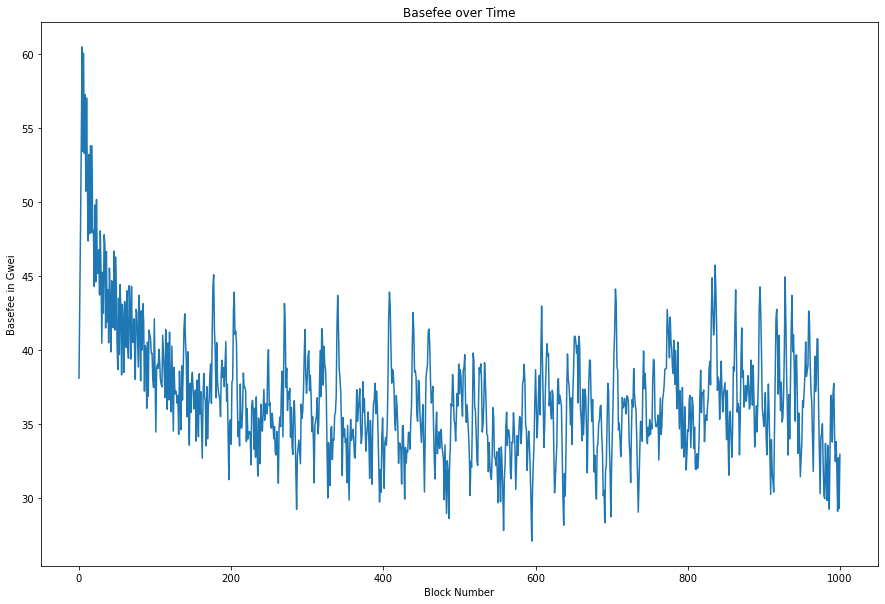

In [8]:
plt.rcParams["figure.figsize"] = (15,10)
plt.title("Basefee over Time")
plt.xlabel("Block Number")
plt.ylabel("Basefee in Gwei")
plt.plot(basefees_data)

# Mempool Analysis
We examine some statistics on the mempools throughout the simulation to quantify congestion.

### Mempool Size Over Time
We show mempool sizes in both total gas and in total number of transactions

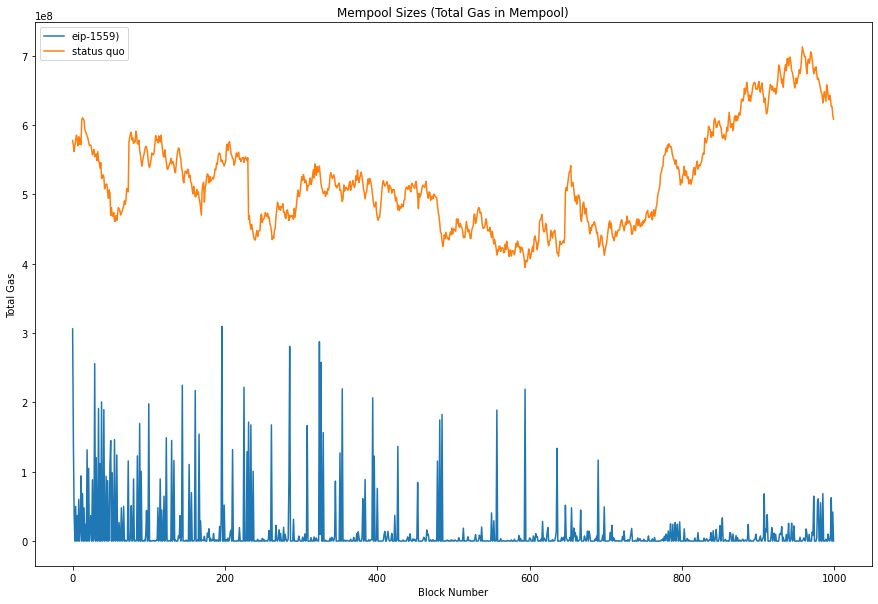

In [9]:
sq_mempool_sizes_gl = [sum(x["gas limit"]) for x in sq_mempools_data]
eip_mempool_sizes_bf_gl = [sum(x["gas limit"]) for x in eip_mempools_bf_data]

plt.title("Mempool Sizes (Total Gas in Mempool)")
plt.xlabel("Block Number")
plt.ylabel("Total Gas")
plt.plot(eip_mempool_sizes_bf_gl, label="eip-1559)")
plt.plot(sq_mempool_sizes_gl, label="status quo")
plt.legend(loc="upper left")

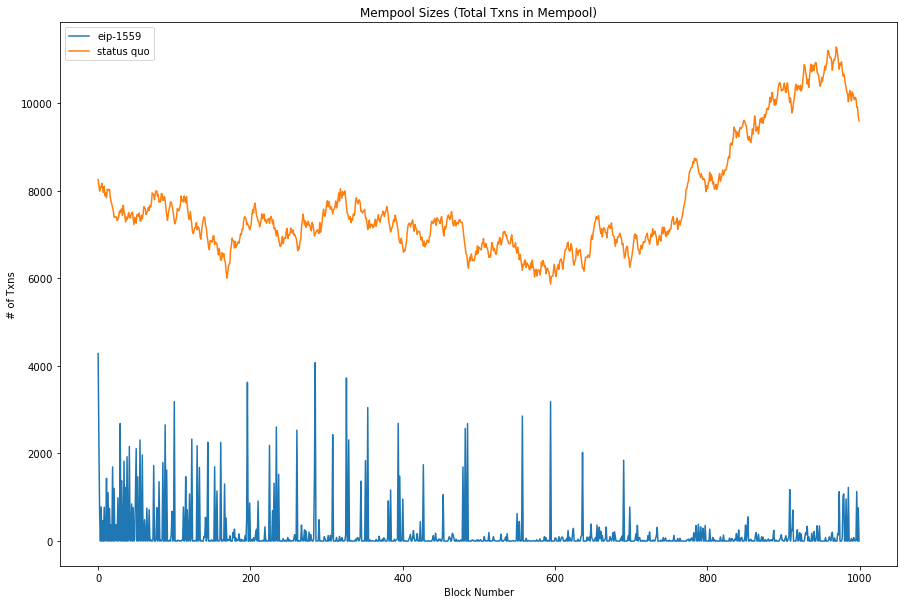

In [10]:
sq_mempool_sizes = [len(x) for x in sq_mempools_data]
eip_mempool_sizes_bf = [len(x) for x in eip_mempools_bf_data]

plt.title("Mempool Sizes (Total Txns in Mempool)")
plt.xlabel("Block Number")
plt.ylabel("# of Txns")
plt.plot(eip_mempool_sizes_bf, label="eip-1559")
plt.plot(sq_mempool_sizes, label="status quo")
plt.legend(loc="upper left")

### Lost Revenue Over Time
Show the total unpaid monetary value in the mempools. 

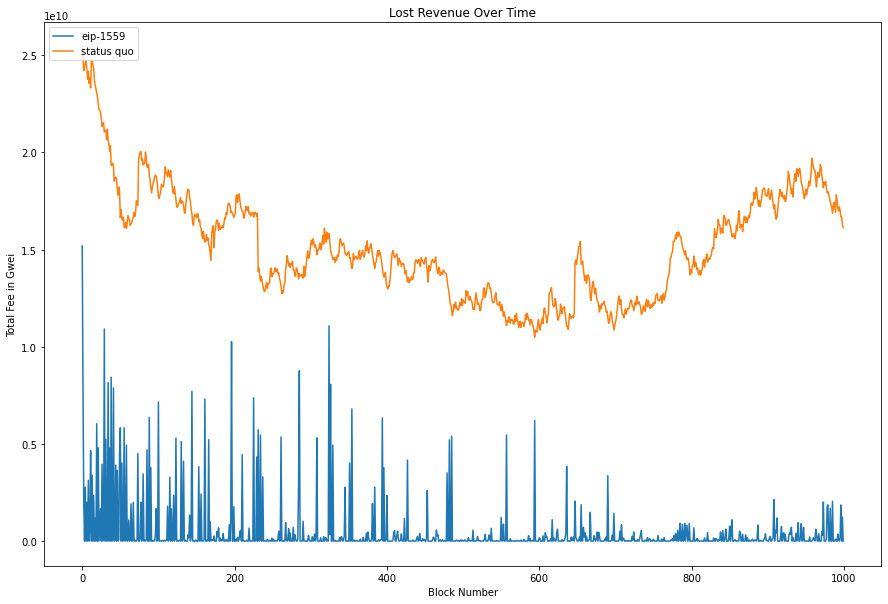

In [11]:
eip_mempool_lrevs = [sum(i["amount paid"]) for i in eip_mempools_bf_data]
sq_mempool_lrevs = [sum(i["amount paid"]) for i in sq_mempools_data]

plt.title("Lost Revenue Over Time")
plt.xlabel("Block Number")
plt.ylabel("Total Fee in Gwei")
plt.plot(eip_mempool_lrevs, label="eip-1559")
plt.plot(sq_mempool_lrevs, label="status quo")
plt.legend(loc="upper left")

### Ratio of Wait Times
After every 100 blocks, we calculate the average wait time of transactions included in blocks, denoted as $\mu$. We then calculate $X/Y$ for $X$ := the number of transactions with wait times $\leq \mu$ and $Y$ := all other transactions. The following is a plot of those ratios. 

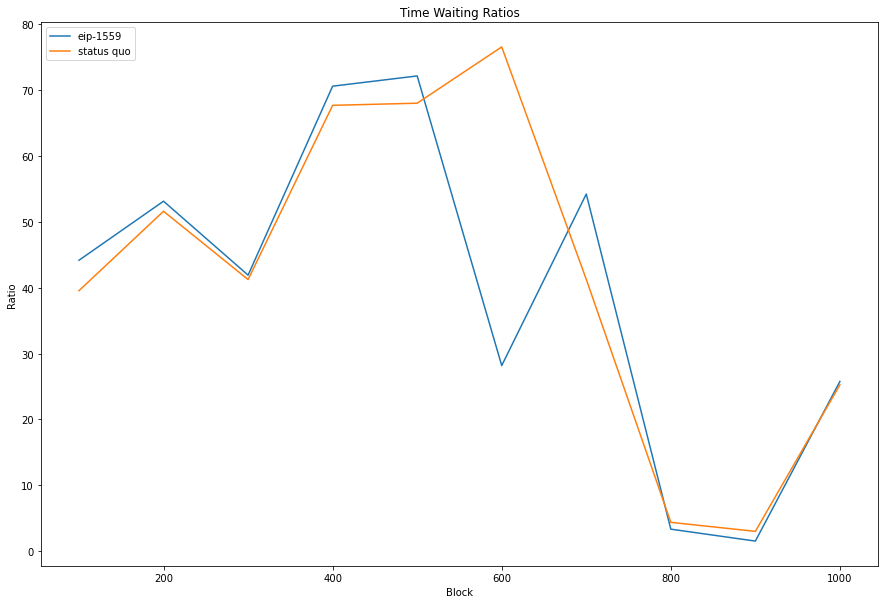

In [12]:
eip_ratios = []
sq_ratios = []

for i in range(len(sq_blocks_data) // 100):
    eip_section = eip_wait_times[i*100:(i+1)*100]
    sq_section = sq_wait_times[i*100:(i+1)*100]
    
    eip_average = sum([sum(x) for x in eip_section]) / 100
    sq_average = sum([sum(x) for x in sq_section]) / 100
    
    X_sq = sum([sum([x for x in y if x <= sq_average ]) for y in sq_section])
    X_eip = sum([sum([x for x in y if x <= eip_average]) for y in eip_section])
    
    sq_waiting = len(sq_mempools_data[100*(i+1) - 1])
    eip_waiting = len(eip_mempools_data[100*(i+1) - 1])
    
    Y_sq = sum([sum([x for x in y if x > sq_average ]) for y in sq_section]) + sq_waiting
    Y_eip = sum([sum([x for x in y if x > eip_average]) for y in eip_section]) + eip_waiting
    
    eip_ratios.append(X_eip / Y_eip)
    sq_ratios.append(X_sq / Y_sq)

plt.title("Time Waiting Ratios")
plt.xlabel("Block")
plt.ylabel("Ratio")
plt.plot([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], eip_ratios, label="eip-1559")
plt.plot([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], sq_ratios, label="status quo")
plt.legend(loc="upper left")

### Average Wait Time of Each Block
Average wait time taken after every 10 blocks

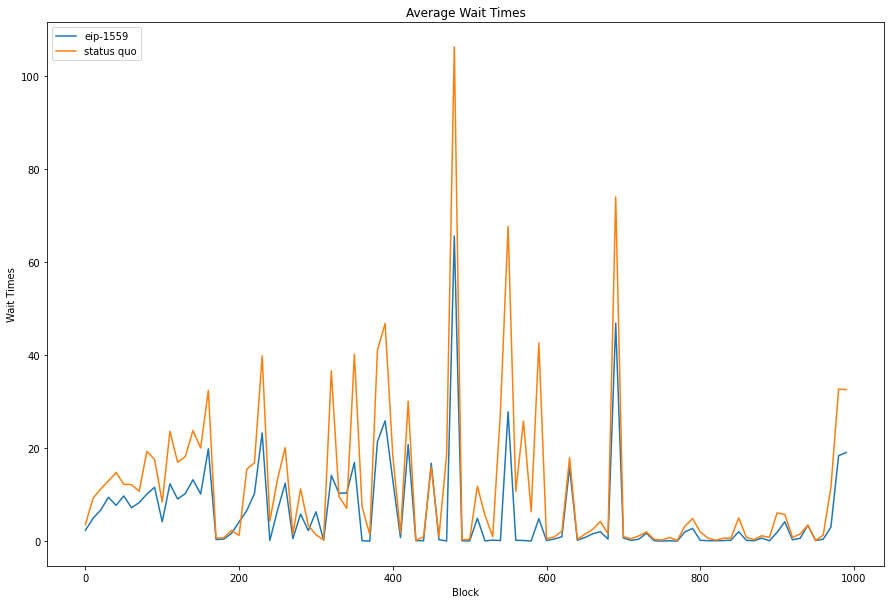

In [13]:
eip_avg_wait = [sum(x)/len(x) for x in eip_wait_times]
sq_avg_wait = [sum(x)/len(x) for x in sq_wait_times]

eip_rolling_avg = [sum(eip_avg_wait[i*10 : (i+1)*10]) / 10 for i in range(len(eip_avg_wait) // 10)]
sq_rolling_avg = [sum(sq_avg_wait[i*10 : (i+1)*10]) / 10 for i in range(len(sq_avg_wait) // 10)]

wait_ratios = [y // x for x, y in zip(eip_rolling_avg, sq_rolling_avg)]

plt.title("Average Wait Times")
plt.xlabel("Block")
plt.ylabel("Wait Times")
plt.plot([i*10 for i in range(100)], eip_rolling_avg, label="eip-1559")
plt.plot([i*10 for i in range(100)], sq_rolling_avg, label="status quo")
# plt.plot([i*10 for i in range(100)], wait_ratios, label="status quo / eip")
plt.legend(loc="upper left")


# Other Metrics

### Total Eth Spent in Both Systems

In [14]:
#compare total amount spent in both simulations
eip_mempool_sums = [sum(x["amount paid"]) for x in eip_mempools_data]
sq_mempool_sums = [sum(x["amount paid"]) for x in sq_mempools_data]
print("total eth spent in eip-1559: ", sum(eip_mempool_sums) / 10**9)
print("total eth spent in status quo: ", sum(sq_mempool_sums) / 10**9)
print("total eth status quo - total eth eip-1559: ", (sum(sq_mempool_sums) / 10**9) - (sum(eip_mempool_sums) / 10**9))

total eth spent in eip-1559:  15136.862396577762
total eth spent in status quo:  15144.382532213396
total eth status quo - total eth eip-1559:  7.520135635633778
